In [1]:
# test cuda
import torch
print(torch.cuda.is_available())

True


/home/xzhang/miniconda3/envs/dip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
import os
import numpy as np
from utils.pre_utils import *
from config import *


npy = fijii_np("/home/xzhang/Documents/我的模型/src/BSREM_it30.img",PETImage_shape)

np.save('BSREM_it30.npy',npy)

In [ ]:
import os
from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import pandas as pd

def readEvent(event_path):
    '''返回tensorboard生成的event文件中所有的scalar的值和名字
            event_path:event文件路径
    '''
    event = event_accumulator.EventAccumulator(event_path)
    event.Reload()
    print("\033[1;34m数据标签：\033[0m")
    print(event.Tags())
    print("\033[1;34m标量数据关键词：\033[0m")
    # print(event.scalars.Keys())
    scalar_name = []
    scalar_data = []
    for name in event.scalars.Keys():
        print(name)
        if 'hp_metric' not in name:
            scalar_name.append(name)
            # event.scalars.Items(name)返回的是list,每个元素为ScalarEvent,有wall_time,step(即我们add_scalar时的step)，value（该scalar在step时的值）
            scalar_data.append(event.scalars.Items(name))
    return scalar_name, scalar_data
def exportToexcel(file_name, excelName):
    '''
        将不同的标量数据导入到同一个excel中，放置在不同的sheet下
            注：excel中sheet名称的命名不能有：/\?*这些符号
    '''
    writer = pd.ExcelWriter(excelName)
    for i in range(len(file_name)):
        event_path = file_name[i]
        scalar_name, scalar_data = readEvent(event_path)
        for i in np.arange(len(scalar_name)):
            scalarValue = scalar_data[i]
            scalarName = scalar_name[i]
            if "/" in scalarName:
                temp_names = scalar_name[i].split("/")
                temp_paths = os.path.split(event_path)
                scalarName = os.path.split(temp_paths[0])[1]
            data = pd.DataFrame(scalarValue)
            data.to_excel(writer, sheet_name=scalarName)
    writer.save()
    print("数据保存成功")
def excel_to_array(excel_path, save_dir=None):
    '''
    保存excel所有表格中的数据到.mat
    Args:
        excel_path: excel表格路径
        save_dir: 保存.mat文件路径
    Returns: 容纳所有表格数据的字典
    '''
    # 将None传递给read_excel函数，返回的是一个key为表名的字典
    f = pd.read_excel(excel_path, sheet_name=None)
    data_dict = dict()
    for key in f.keys():
        sheet = f[key]
        sheet = sheet.head(n=-1)
        value = sheet.values
        # 只保留最后两列,一列是step,另一列是值
        data_dict[key] = value[:, 2:4]
        # print(value)
    if save_dir is not None:
        save_dict_as_mat(data_dict, save_dir)
    return data_dict

def save_dict_as_mat(dict, save_dir):
    scio.savemat(save_dir, dict)

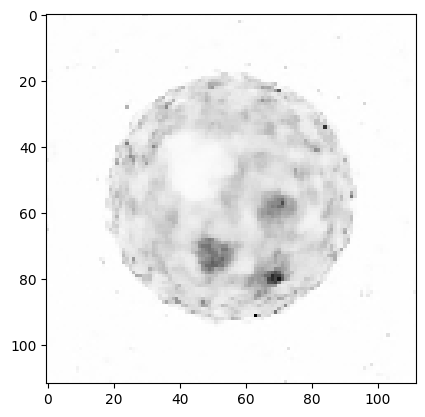

In [11]:
# plot image
import matplotlib.pyplot as plt
import numpy as np
from utils.pre_utils import *
from config import *

img = fijii_np('output_images/output_3999.img',PETImage_shape)
img_reversed = np.max(img)- img
plt.imshow(img_reversed,cmap='gray')
plt.show()